In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
(ds_train,ds_test),ds_info=tfds.load(
    'mnist',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/incomplete.NBQ1Q5_3.0.1/',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""

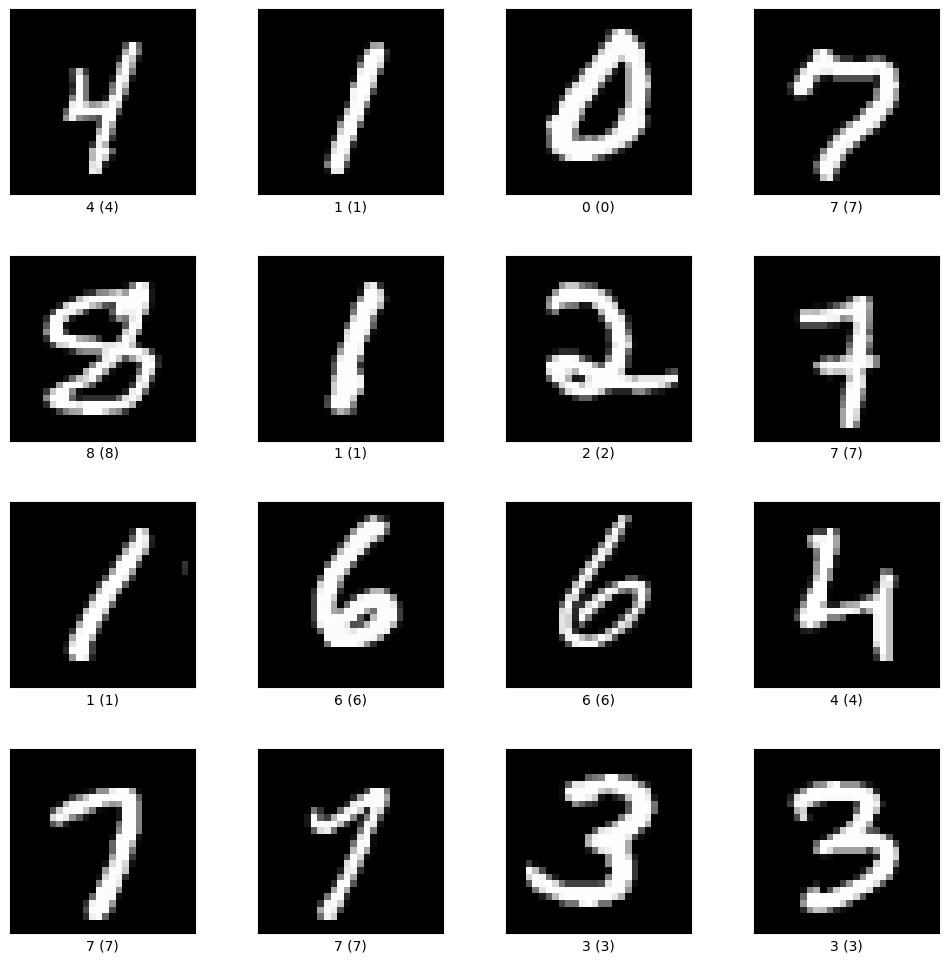

In [4]:
fig=tfds.show_examples(ds_train,ds_info,rows=4,cols=4)

In [5]:
def normalize(image,label):
  return tf.cast(image,tf.float32)/255.0, label

In [6]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
BATCH_SIZE=64
ds_train=ds_train.map(normalize,num_parallel_calls=AUTOTUNE)
ds_train=ds_train.batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE)

ds_test=ds_test.map(normalize,num_parallel_calls=AUTOTUNE)
ds_test=ds_test.batch(BATCH_SIZE)
ds_test=ds_test.prefetch(AUTOTUNE)

In [7]:
model=keras.Sequential([
    keras.Input(shape=(28,28,1)),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(10,activation='softmax')
])

In [8]:
model.compile(optimizer=keras.optimizers.Adam(3e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
model.fit(ds_train,epochs=10,verbose=2,validation_data=ds_test)

Epoch 1/10
938/938 - 11s - 12ms/step - accuracy: 0.8766 - loss: 0.4671 - val_accuracy: 0.9255 - val_loss: 0.2604
Epoch 2/10
938/938 - 2s - 2ms/step - accuracy: 0.9314 - loss: 0.2396 - val_accuracy: 0.9431 - val_loss: 0.1966
Epoch 3/10
938/938 - 3s - 3ms/step - accuracy: 0.9477 - loss: 0.1846 - val_accuracy: 0.9562 - val_loss: 0.1554
Epoch 4/10
938/938 - 2s - 2ms/step - accuracy: 0.9587 - loss: 0.1483 - val_accuracy: 0.9637 - val_loss: 0.1289
Epoch 5/10
938/938 - 4s - 4ms/step - accuracy: 0.9656 - loss: 0.1236 - val_accuracy: 0.9680 - val_loss: 0.1109
Epoch 6/10
938/938 - 4s - 4ms/step - accuracy: 0.9710 - loss: 0.1055 - val_accuracy: 0.9711 - val_loss: 0.0977
Epoch 7/10
938/938 - 2s - 3ms/step - accuracy: 0.9749 - loss: 0.0918 - val_accuracy: 0.9738 - val_loss: 0.0878
Epoch 8/10
938/938 - 3s - 3ms/step - accuracy: 0.9777 - loss: 0.0812 - val_accuracy: 0.9755 - val_loss: 0.0802
Epoch 9/10
938/938 - 4s - 4ms/step - accuracy: 0.9798 - loss: 0.0729 - val_accuracy: 0.9768 - val_loss: 0.0745

In [57]:
(ds_train,ds_test),ds_info=tfds.load(
    'imdb_reviews',
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [58]:
ds_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

In [59]:
tokenizer=tfds.deprecated.text.Tokenizer()

In [61]:
def build_vocabulary():
  vocabulary=set()
  for text,_ in ds_train:
    vocabulary.update(tokenizer.tokenize(text.numpy().lower()))
  return vocabulary


In [62]:
vocabulary=build_vocabulary()

In [63]:
len(vocabulary)

74893

In [64]:
encoder=tfds.deprecated.text.TokenTextEncoder(vocabulary,oov_token='<UNK>',tokenizer=tokenizer,lowercase=True)

In [65]:
def my_encodings(text_tensor,label):
  return encoder.encode(text_tensor.numpy()),label

In [66]:
def encoding_map(text,label):
  encoded_text,label=tf.py_function(my_encodings,inp=[text,label],Tout=(tf.int64,tf.int64))
  encoded_text.set_shape([None])
  label.set_shape([])
  return encoded_text,label

In [67]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
BATCH_SIZE=32
ds_train=ds_train.map(encoding_map,num_parallel_calls=AUTOTUNE)
ds_train=ds_train.padded_batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE)

ds_test=ds_test.map(encoding_map)
ds_test=ds_test.padded_batch(BATCH_SIZE)
ds_test=ds_test.prefetch(AUTOTUNE)

In [68]:
model=keras.Sequential([
    layers.Masking(mask_value=0),
    layers.Embedding(input_dim=len(vocabulary)+2,output_dim=300),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')

]
)

In [69]:
model.compile(optimizer=keras.optimizers.Adam(3e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [71]:
model.fit(ds_train,epochs=10,verbose=2,validation_data=ds_test)

Epoch 1/10
782/782 - 46s - 59ms/step - accuracy: 0.8862 - loss: 0.2769 - val_accuracy: 0.8508 - val_loss: 0.3387
Epoch 2/10
782/782 - 46s - 59ms/step - accuracy: 0.8946 - loss: 0.2594 - val_accuracy: 0.8550 - val_loss: 0.3335
Epoch 3/10
782/782 - 46s - 59ms/step - accuracy: 0.9027 - loss: 0.2440 - val_accuracy: 0.8552 - val_loss: 0.3351
Epoch 4/10
782/782 - 46s - 59ms/step - accuracy: 0.9127 - loss: 0.2229 - val_accuracy: 0.8359 - val_loss: 0.3769
Epoch 5/10
782/782 - 46s - 58ms/step - accuracy: 0.9212 - loss: 0.2064 - val_accuracy: 0.8216 - val_loss: 0.4211
Epoch 6/10
782/782 - 46s - 59ms/step - accuracy: 0.9262 - loss: 0.1974 - val_accuracy: 0.8052 - val_loss: 0.4827
Epoch 7/10
782/782 - 47s - 60ms/step - accuracy: 0.9302 - loss: 0.1892 - val_accuracy: 0.7845 - val_loss: 0.5702
Epoch 8/10
782/782 - 45s - 57ms/step - accuracy: 0.9308 - loss: 0.1840 - val_accuracy: 0.8159 - val_loss: 0.4575
Epoch 9/10
782/782 - 46s - 58ms/step - accuracy: 0.9256 - loss: 0.1912 - val_accuracy: 0.8520 - 